# Baseline Models

Train some baseline models.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Import Scipy Models
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Train/Test Split

In [2]:
data = pd.read_csv('../data/clean_data.csv')

_FEATURES = ['Age', 'booking_window_days', 'Hipertension', 'Scholarship', 
             'Diabetes', 'Handcap', 'SMS_received', 'ScheduledHour', 
             'AppointmentDayOfWeek']
_TARGET = 'No-show'

In [5]:
def add_features(data, train_index, test_index):
    # Calculate the user history
    train = data.iloc[train_index]
    train = train.join(train.groupby('PatientId')['No-show'].agg(np.mean), on='PatientId', rsuffix='_user_mean')
    train = train.join(train.groupby('Neighbourhood')['No-show'].agg(np.mean), on='Neighbourhood', rsuffix='_neighbourhood_mean')
    train = train.join(train.groupby('PatientId')['No-show'].agg('sum'), on='PatientId', rsuffix='_sum')
    #train = train.join(train.groupby('PatientId')['Age'].count(), on='PatientId', rsuffix='_count')

    test = data.iloc[test_index]

    test = pd.merge(test, train[['PatientId', 'No-show_user_mean']], on='PatientId', how='left') 
    test.at[test['No-show_user_mean'].isna(), 'No-show_user_mean'] = 1

    test = pd.merge(test, train[['PatientId', 'No-show_neighbourhood_mean']], on='PatientId', how='left') 
    test.at[test['No-show_neighbourhood_mean'].isna(), 'No-show_neighbourhood_mean'] = 1

    test = pd.merge(test, train[['PatientId', 'No-show_sum']], on='PatientId', how='left')
    test.at[test['No-show_sum'].isna(), 'No-show_sum'] = 0

    #test = pd.merge(test, train[['PatientId', 'Age_count']], on='PatientId', how='left')
    #test.at[test['Age_count'].isna(), 'Age_count'] = 0

    X_train = train[_FEATURES + ['No-show_user_mean', 'No-show_neighbourhood_mean']].values
    y_train = train[_TARGET].values

    X_test = test[_FEATURES + ['No-show_user_mean', 'No-show_neighbourhood_mean']].values
    y_test = test[_TARGET].values

    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    
    return X_train, X_test, y_train, y_test


train_index = random.sample(range(0, data.shape[0]), int(data.shape[0] * 0.8))
test_index = [i for i in range(0, data.shape[0]) if i not in train_index]
print('Done')
X_train, X_test, y_train, y_test = add_features(data, train_index, test_index)

Done


## Models

### Logistic Regression

/Users/thomascartwright/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9537153017987591


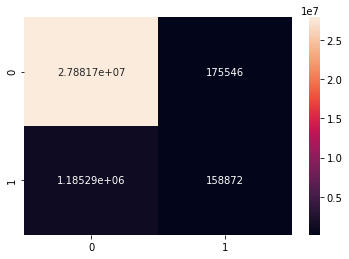

In [6]:
lr = LogisticRegression(random_state=0, class_weight='balanced')
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))

df_cm = pd.DataFrame(confusion_matrix(y_test, lr.predict(X_test)), range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt='g') # font size
plt.show()

### Stochastic Gradient Descent (SGD)

/Users/thomascartwright/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.9434037109822736


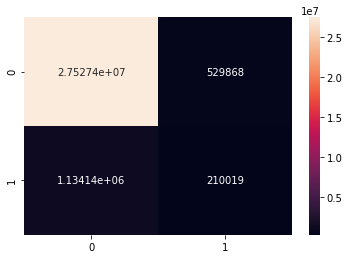

In [7]:
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=5, class_weight='balanced')
sgd.fit(X_train, y_train)
print(sgd.score(X_test, y_test))

df_cm = pd.DataFrame(confusion_matrix(y_test, sgd.predict(X_test)), range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt='g') # font size
plt.show()

### K-Nearest Neighbours

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
print(neigh.score(X_test, y_test))

df_cm = pd.DataFrame(confusion_matrix(y_test, neigh.predict(X_test)), range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt='g') # font size
plt.show()

This probably doesn't perform as well since of the high dimensionality.

### Naive Bayes

0.954825113651128


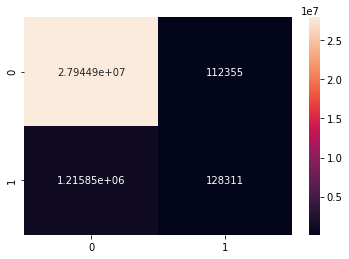

In [8]:
naive = GaussianNB()
naive.fit(X_train, y_train)
print(naive.score(X_test, y_test))

df_cm = pd.DataFrame(confusion_matrix(y_test, naive.predict(X_test)), range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt='g') # font size
plt.show()

### Decision Trees

0.9586409209363642


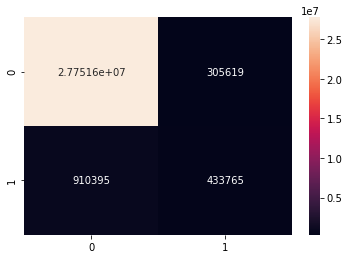

In [9]:
dt = DecisionTreeClassifier(random_state=0, class_weight='balanced')
dt.fit(X_train, y_train)
print(dt.score(X_test, y_test))

df_cm = pd.DataFrame(confusion_matrix(y_test, dt.predict(X_test)), range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt='g') # font size
plt.show()

### Random Forrest Classifier

/Users/thomascartwright/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.953685575302928


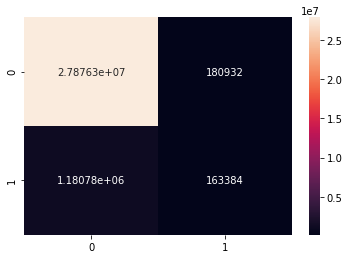

In [10]:
rfc = RandomForestClassifier(n_jobs=2, random_state=0, class_weight='balanced')
rfc.fit(X_train, y_train)
print(rfc.score(X_test, y_test))

df_cm = pd.DataFrame(confusion_matrix(y_test, rfc.predict(X_test)), range(2), range(2))
sns.heatmap(df_cm, annot=True, fmt='g') # font size
plt.show()